<a href="https://colab.research.google.com/github/lprazeres/Arsenal_Predictions_MLClassification/blob/main/arsenal_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
data = pd.read_excel('arsenal_dataset.xlsx')
df = data.copy()


In [ ]:
df = df.drop(['GF', 'GA', 'Attendance'], axis=1)
df

In [ ]:
def convert_time_to_period(time):
    hour = int(time.split(":")[0])
    if 13 <= hour < 17:
        return "Day"
    else:
        return "Night"

df['Time'] = df['Time'].apply(convert_time_to_period)
df

In [ ]:
def get_season(date):
    month = pd.to_datetime(date).month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df['SeasonPeriod'] = df['Date'].apply(get_season)
df

In [ ]:
df['Opponent'] = df['Opponent'].str.replace(r'^[a-z]{2,3} ', '', regex=True)

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
def fill_missing_values_with_median(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df.groupby('Season')[col].transform(lambda x: x.fillna(x.median()))
        else:
            df[col] = df.groupby('Season')[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))
    return df

df = fill_missing_values_with_median(df)

In [ ]:
df['Date'] = pd.to_datetime(df['Date']).map(pd.Timestamp.toordinal)
df

In [ ]:
categorical_features = ['Time', 'Comp', 'Day', 'Venue', 'Opponent', 'SeasonPeriod', 'Season']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df_encoded

In [ ]:
X = df_encoded.drop('Result', axis=1)
y = df_encoded['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
neural_network = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
logistic_regression.fit(X_train, y_train)
neural_network.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MLPClassifier(max_iter=1000, random_state=42)

In [ ]:
models = {
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "Logistic Regression": logistic_regression,
    "Neural Network": neural_network
}


results = []

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    })


results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0        Decision Tree  0.723684   0.730619  0.723684  0.726253
1        Random Forest  0.789474   0.758772  0.789474  0.759192
2  Logistic Regression  0.631579   0.596108  0.631579  0.607703
3       Neural Network  0.605263   0.366343  0.605263  0.456428


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


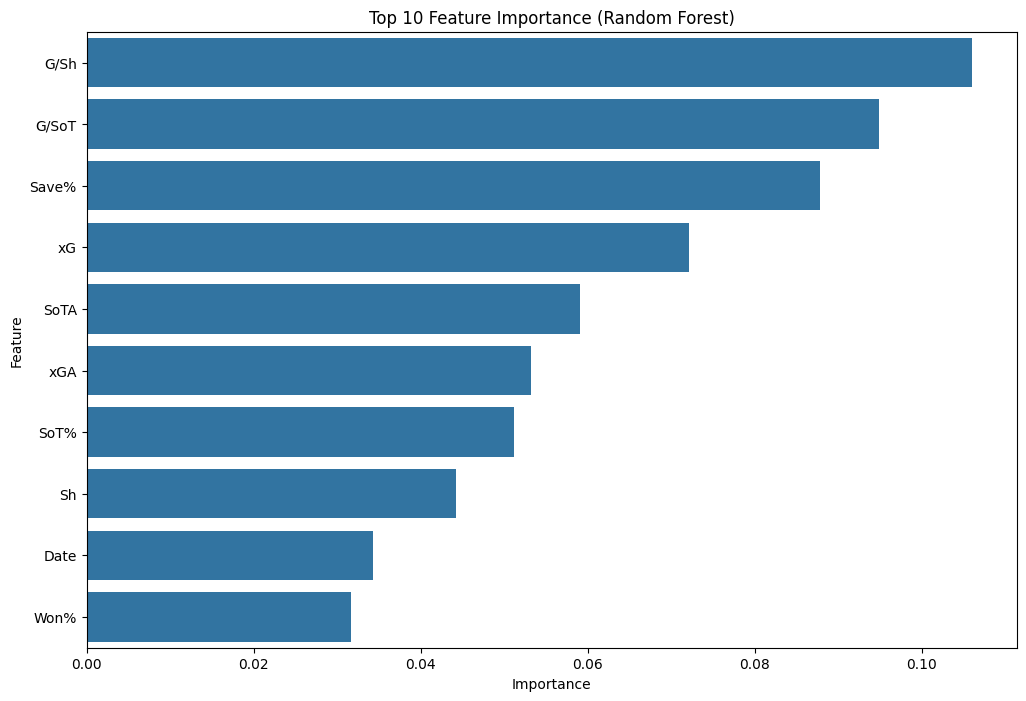

In [ ]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': random_forest.feature_importances_
})


feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


top_10_features = feature_importances.head(10)


plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Feature Importance (Random Forest)')
plt.show()

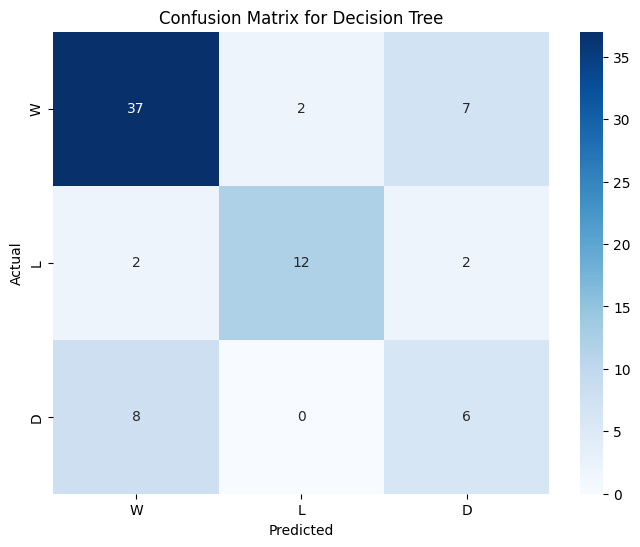

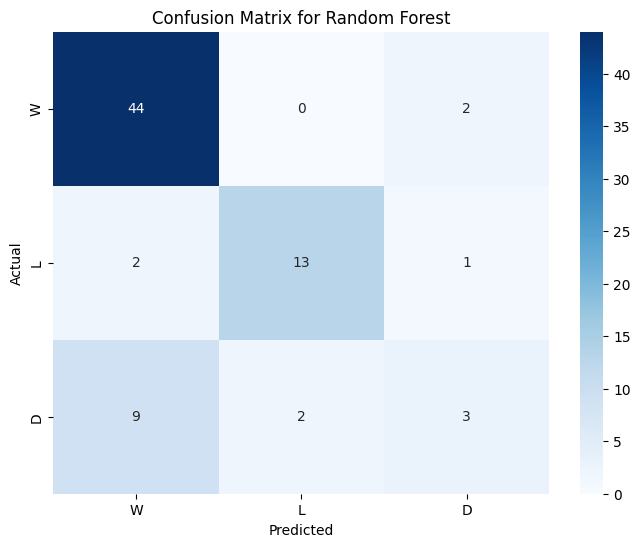

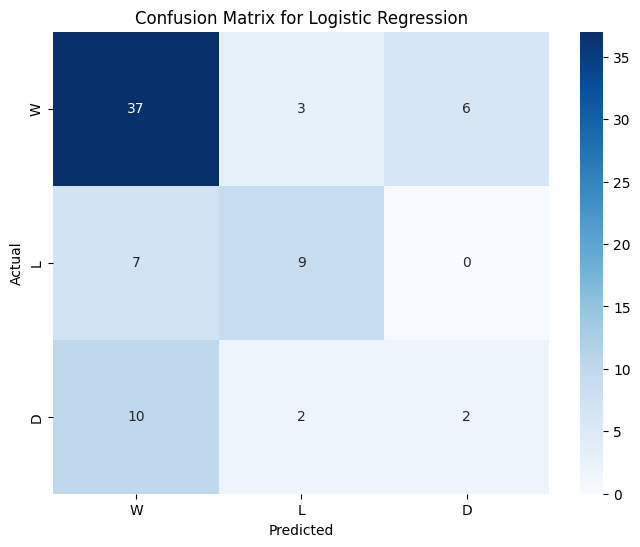

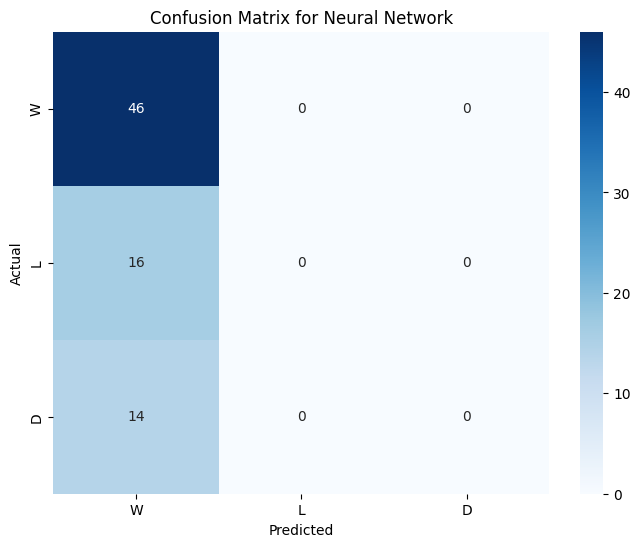

In [ ]:
for model_name, model in models.items():

    y_pred = model.predict(X_test)


    cm = confusion_matrix(y_test, y_pred, labels=['W', 'L', 'D'])


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['W', 'L', 'D'], yticklabels=['W', 'L', 'D'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
def predict_new_game(model, new_data):

    missing_cols = set(X_train.columns) - set(new_data.columns)


    for col in missing_cols:
        new_data[col] = 0


    new_data = new_data[X_train.columns]


    prediction = model.predict(new_data)
    return prediction[0]


new_game = pd.DataFrame({
    'xG': [0],
    'xGA': [0],
    'SoT%': [0],
    'G/Sh': [0.2],
    'G/SoT': [0],
    'SoTA': [5],
    'Save%': [1],
    'Sh': [0],
    'Won%': [0],
}, index=[0])


result = predict_new_game(random_forest, new_game)
print("Predicted Result:", result)

Predicted Result: L


Result                             D          L          W
SeasonPeriod SeasonPeriod                                 
Fall         Fall          18.584071  15.929204  65.486726
Spring       Spring        16.161616  27.272727  56.565657
Summer       Summer        13.513514  32.432432  54.054054
Winter       Winter        20.472441  30.708661  48.818898


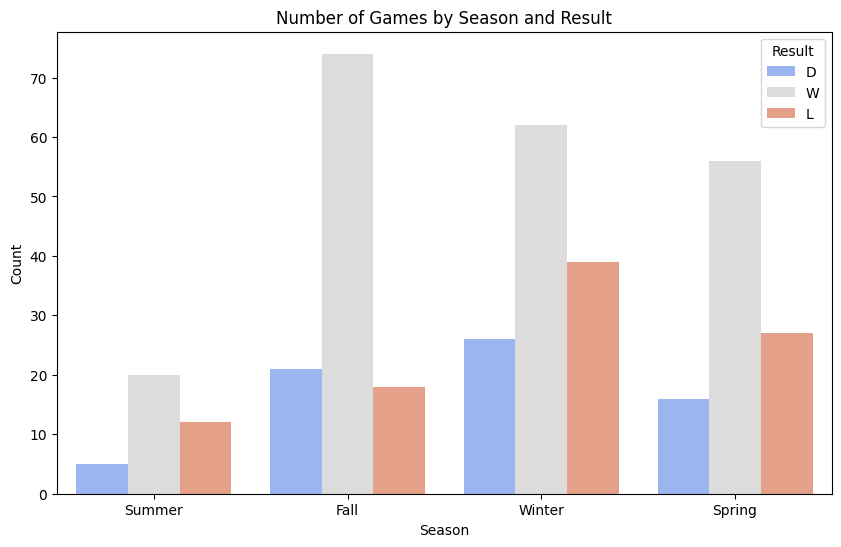

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='SeasonPeriod', hue='Result', palette='coolwarm')
plt.title('Number of Games by Season and Result')
plt.xlabel('Season')
plt.ylabel('Count')
result_percentage_season = df.groupby(['SeasonPeriod', 'Result']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
print(result_percentage_season)
plt.show()



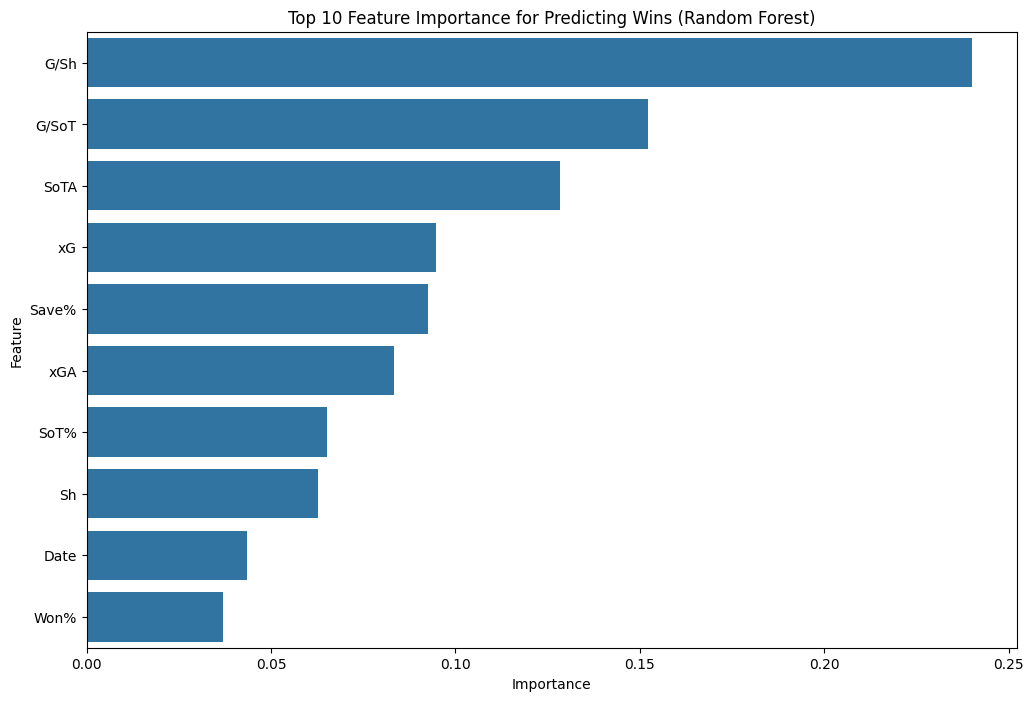

In [ ]:

df['Is_Win'] = (df['Result'] == 'W').astype(int)


X = df[top_10_features['Feature'].tolist()]
y = df['Is_Win']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_binary = RandomForestClassifier(random_state=42)
rf_binary.fit(X_train, y_train)


feature_importances_win = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_binary.feature_importances_
})


feature_importances_win = feature_importances_win.sort_values(by='Importance', ascending=False)


top_10_features_win = feature_importances_win.head(10)


plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_features_win)
plt.title('Top 10 Feature Importance for Predicting Wins (Random Forest)')
plt.show()